## ABM prototype

Check that the working directory is within the main 'mhm/' folder, otherwise change it.

In [1]:
import os
WORK_DIR = os.getcwd()
correct_folder = '/Users/evaviviani/github/mhm'

if WORK_DIR == correct_folder:
    print('you are already in the correct folder')
elif WORK_DIR != correct_folder:
    os.chdir(correct_folder)
    print('you are NOW in the correct folder')

you are NOW in the correct folder


In [45]:
from mhm.agent import Population
import mhm.utils as ut
import numpy as np
import pandas as pd
import random

In [136]:
from mhm.distributions import generate_age_distribution

In [137]:
generate_age_distribution(n_people=10, n_age_groups=4, min_age=24, max_age=65, prob=[.25, .23, .31, .21])


[40, 52, 48, 34, 24, 31, 39, 40, 52, 54]

## How agents work

Agents have three characteristics:

1. **features**, immutable variables (e.g., gender, age, etc)
2. **states**, mutable variables (e.g., employed, infected, mental health and number of contacts)
3. **actions**, functions which change the agents' status (e.g., go to work, socialise)

## How a simulation works

Every day an agent can choose an action (ideally multiple actions a day). The simulation will start from day = 0 up until max(steps). At every step, it will check the type of agents' features -> states and thus choices and will apply some lockdown policies. These policies will affect the agents' availability of actions and therefore their states.

We will collect the output of those states as a dataframe every step, i.e., every day.

### Generate a population with given paramenters

We build a population of n agents with the following parameters:

In [57]:
parameters = {'n' : 50,
              'n_age_groups':4,
              'min_age':24,
              'max_age': 65,
              'age_strata': [.25, .23, .31, .21],
              'low_education': .11,
              'medium_education': .25,
              'high_education': .64,
              'employed_true': .76,
              'employed_false_seeking': .155,
              'employed_false_other': .085,
              'single': .20,
              'married': .41,
              'live_in_partner': .29,
              'in_relationship_no_cohabitation': .09,
              'other_relationship': .01,
              '%_gender':50,
              '%_depression': 20,
              '%_addiction': 5,
              '%_fatigue': 5,
              '%_burnout': 73,
              '%_child': 7,
              '%_child_inhouse': 58,
              '%_single_parent': 5,
              'finance_difficulties_false': 75,
              'finance_difficulties_many': 12,
              'finance_difficulties_some': 13,
              'health_difficulties_false': 65,
              'health_difficulties_many': 14,
              'health_difficulties_some': 20,
              'housing_difficulties_false': 79,
              'housing_difficulties_many': 3,
              'housing_difficulties_some': 18,
              'partner_difficulties_false': 67,
              'partner_difficulties_many': 5,
              'partner_difficulties_some': 18,
              'partner_difficulties_other': 10,
              
}

In [58]:
random.seed(10)

people = Population(parameters=parameters)

Plot agents' characteristics at the population level

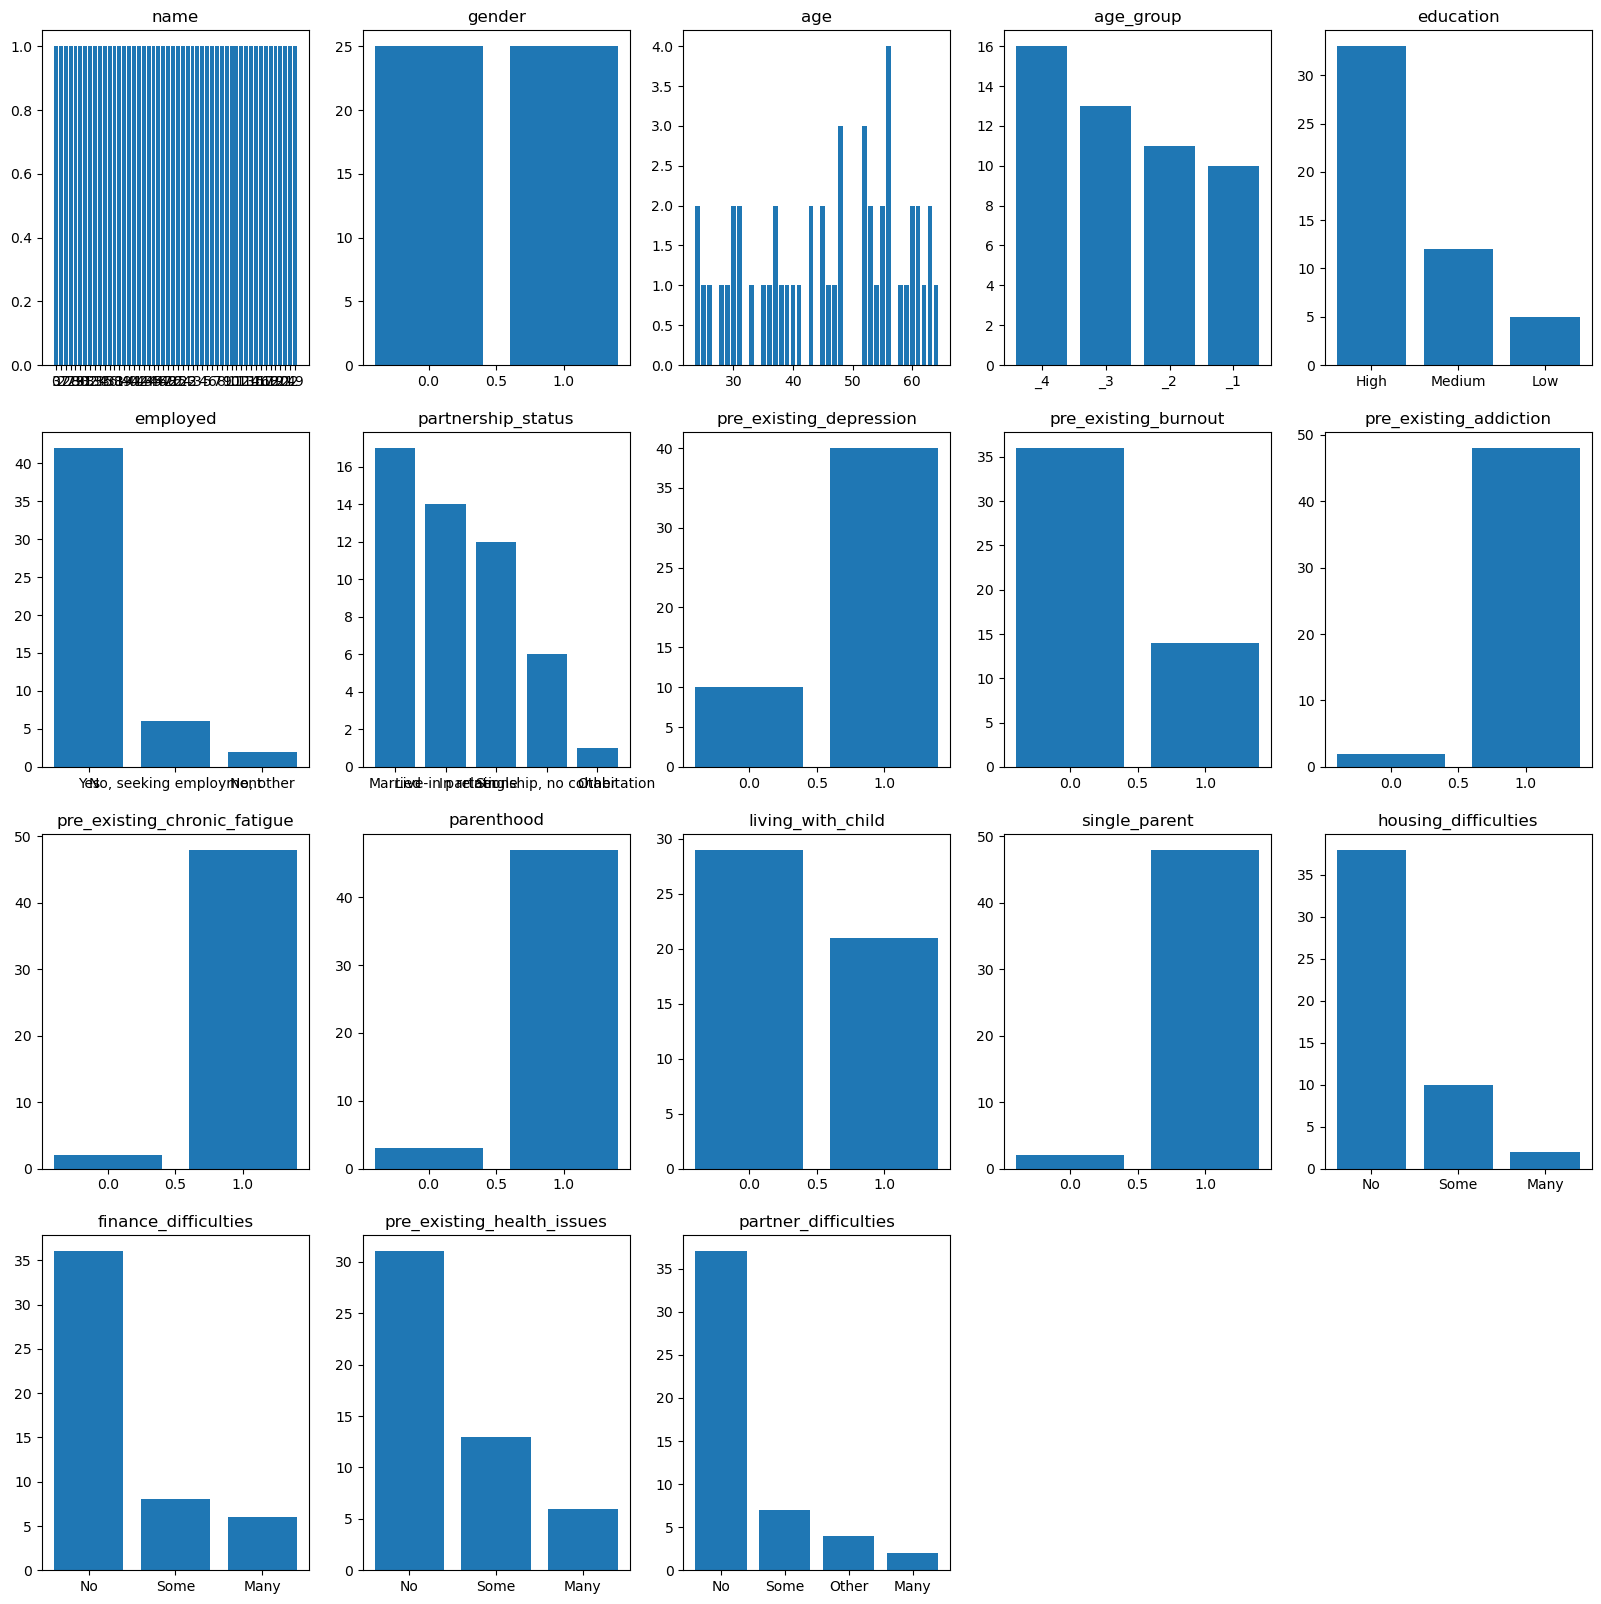

In [59]:
people.plot_summary()

An approach can be to run a simple simulation whereby over 100 days (i.e., 100 steps), agents go to work (if employed), and generally socialise:

In [33]:
steps = 100

state_history = []
for step in range(steps):
    day_states = []
    for agent in people.population:
        
        if agent.state.employed:
            agent.go_to_work()
        
        agent.socialise()
        
        day_states.append(agent.state)
    
    state_history.append(day_states)

In [34]:
### This will be their mental health (for example):

In [35]:
mh_employed = [s.mental_health for s in state_history[-1] if s.employed]
mh_unemployed = [s.mental_health for s in state_history[-1] if not(s.employed)]

In [36]:
print(np.mean(mh_employed))
print(np.mean(mh_unemployed))

402.0
302.0


However, this approach implies that we go directly from the features, to the mental health. Instead, we want this to interact with the agents' goals, which in turn are limited/influenced by the type of lockdown. All of which has to result in a mental health outcome.

It's easier to approach this problem by thinking about a world made of agents, who can choose to make actions every day. The actions, in interaction with the agents' features, have a modulating effect on two dependent variables: number of contacts, and mental health. Actions available to the agents are dictated by the world's lockdown state which can limit the type of actions.

These are the actions that are available to agents:

- **go_to_work** = This action includes any work-related activity outside of the home, i.e., go work at the hospital, at school, at a construction site.
- **maintain_physical_distance** = This action includes any guidance on mantaining a safe space from others, i.e., mantaining 1.5m distance, do not shake hands, host no more than X people at home.
- **stay_at_home** = This action includes guidance on working from home and quarantining.
- **exercise** = This action includes guidance on sport activities allowed, i.e., taking a walk in the park, going to the gym, walking your dog or doing yoga
- **socialise** = This includes all social activities to do together with at least another agent, i.e., going to the cinema, to cafes, to museums, etc
- **travel** = This includes taking a train, a bus, a plane or driving the car
- **seek_help** = This includes seeking help in case an agent feels his mental health deteriorating, i.e., from a mental health professional or calling a helpline
- **negative_coping** = This relates negative coping strategies, such as smoking more tabacco, using drugs, drinking alcohol, losing faith in the government
- **positive_coping** = This relates positive coping strategies, such as learn new skills, keep contacts with distant relatives online, keeping a diary or playing indoor games.

We can have three types of lockdowns: easy, medium and hard. We also have a no-lockdown policy. Each one of those policies will affect the probability that each action get chosen by the agents.


I'm goint to try to build this system now. First lets convert our agents' categorical variables into numerical variables. We do that via one-hot encoding.

In [60]:
features_df = ut.make_features_dataframe(people.population)
features_df.head()

,name,gender,age,age_group,education,employed,partnership_status,pre_existing_depression,pre_existing_burnout,pre_existing_addiction,pre_existing_chronic_fatigue,parenthood,living_with_child,single_parent,housing_difficulties,finance_difficulties,pre_existing_health_issues,partner_difficulties
0,0,1,41,_2,High,Yes,Married,1,0,1,1,1,1,1,No,No,Many,No
1,1,1,56,_4,High,Yes,Single,1,1,1,1,1,1,1,Many,No,Many,Some
2,2,1,38,_2,High,Yes,Single,1,0,1,1,1,0,1,No,No,No,No
3,3,1,48,_3,Medium,Yes,Married,0,0,1,1,1,0,1,Some,No,Some,No
4,4,1,39,_2,High,"No, seeking employment",Single,1,0,1,1,1,1,1,Some,No,Some,No


In [61]:
categorical_variables = ['age_group', 'education', 'employed', 
                         'partnership_status', 'housing_difficulties', 'finance_difficulties',
                         'pre_existing_health_issues', 'partner_difficulties']
encoded_features = ut.one_hot_encoding(features_df, cols = categorical_variables)
encoded_features.head()

,name,gender,age,pre_existing_depression,pre_existing_burnout,pre_existing_addiction,pre_existing_chronic_fatigue,parenthood,living_with_child,single_parent,...,finance_difficulties_Many,finance_difficulties_No,finance_difficulties_Some,pre_existing_health_issues_Many,pre_existing_health_issues_No,pre_existing_health_issues_Some,partner_difficulties_Many,partner_difficulties_No,partner_difficulties_Other,partner_difficulties_Some
0,0,1,41,1,0,1,1,1,1,1,...,0,1,0,1,0,0,0,1,0,0
1,1,1,56,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,0,1
2,2,1,38,1,0,1,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
3,3,1,48,0,0,1,1,1,0,1,...,0,1,0,0,0,1,0,1,0,0
4,4,1,39,1,0,1,1,1,1,1,...,0,1,0,0,0,1,0,1,0,0


I have made two matrices (stored in the /hypotheses/ folder) whereby I have put positive and negative values directly reflecting the LA's hypothesis of the effects of the lockdown policies on the mental health and number of contacts. For example, this is one of the hypotheses:

- Younger adults (under 35) had their social livels (interactions with social networks outside the household) more severely disrupted than older adults

This hypothesis is reflected in both matrices in the `socialise` action row, in the `age_group__1` and `age_group__2` columns the value affecting mental health is much more positive than `age_group__3` and `age_group__4` groups. As such, in a condition of lockdown whereby it is not possible to socialise outside of the household, we will have these values withdrawn:

In [113]:
actions_effects_on_contacts = pd.read_csv('hypotheses/action_effects_on_contacs.csv', header=0, delimiter=';')
actions_effects_on_mh = pd.read_csv('hypotheses/action_effects_on_mh.csv', header=0, delimiter=';')

In [114]:
actions_effects_on_mh[actions_effects_on_mh['actions'] == 'socialise'][['age_group__1', 'age_group__2', 'age_group__3', 'age_group__4']]



,age_group__1,age_group__2,age_group__3,age_group__4
4,1.0,1.0,0.5,0.5


Let's say for example that we are in an hypothethical situation in which all agents do all the actions (not possible in real life, but it is for the sake of explanation). We will have each agent's mental health and number of contacts affected based on (1) their features (rows in the `encoded_features`) by (2) their actions (rows in `actions_effects_on_mh` and `actions_effects_on_contacts` respectively).

In [115]:
def find_non_matching_columns(df1, df2):
    # Get the column names of each dataframe
    df1_columns = set(df1.columns)
    df2_columns = set(df2.columns)

    # Find the non-matching columns
    non_matching_columns = df1_columns.symmetric_difference(df2_columns)

    return non_matching_columns


In [116]:
find_non_matching_columns(actions_effects_on_mh, actions_effects_on_contacts)

set()

In [117]:
actions_effects_on_mh.iloc[1, 2:]

name                                                   0.0
gender                                                 0.0
age                                                    0.0
pre_existing_depression                               -1.0
pre_existing_burnout                                  -1.0
pre_existing_addiction                                -1.0
pre_existing_chronic_fatigue                          -1.0
parenthood                                             0.0
living_with_child                                      0.0
single_parent                                          0.0
age_group__1                                           0.0
age_group__2                                           0.0
age_group__3                                           0.0
age_group__4                                           0.0
education_High                                         0.0
education_Low                                          0.0
education_Medium                                       0

In [129]:
print(actions_effects_on_mh.shape)
print(actions_effects_on_contacts.shape)
print(encoded_features.shape)


(9, 40)
(9, 40)
(50, 38)


In [119]:
len(actions_effects_on_mh.columns[2:,])

38

In [120]:
actions_effects_on_mh.iloc[1, 2:]

name                                                   0.0
gender                                                 0.0
age                                                    0.0
pre_existing_depression                               -1.0
pre_existing_burnout                                  -1.0
pre_existing_addiction                                -1.0
pre_existing_chronic_fatigue                          -1.0
parenthood                                             0.0
living_with_child                                      0.0
single_parent                                          0.0
age_group__1                                           0.0
age_group__2                                           0.0
age_group__3                                           0.0
age_group__4                                           0.0
education_High                                         0.0
education_Low                                          0.0
education_Medium                                       0

In [130]:
actions_effects_on_contacts

,actions,baseline,name,gender,age,pre_existing_depression,pre_existing_burnout,pre_existing_addiction,pre_existing_chronic_fatigue,parenthood,...,finance_difficulties_No,finance_difficulties_Some,finance_difficulties_Many,pre_existing_health_issues_Many,pre_existing_health_issues_No,pre_existing_health_issues_Some,partner_difficulties_Many,partner_difficulties_No,partner_difficulties_Some,partner_difficulties_Other
0,go_to_work,0,0.0,0.0,0.0,-0.5,-0.5,-0.5,-0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,maintain_physical_distance,0,0.0,0.0,0.0,-0.5,-0.5,-0.5,-0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,stay_at_home,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,exercise,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,socialise,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,travel,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,seek_help,0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,negative_coping,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,positive_coping,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
encoded_features.head(2)

,name,gender,age,pre_existing_depression,pre_existing_burnout,pre_existing_addiction,pre_existing_chronic_fatigue,parenthood,living_with_child,single_parent,...,finance_difficulties_Many,finance_difficulties_No,finance_difficulties_Some,pre_existing_health_issues_Many,pre_existing_health_issues_No,pre_existing_health_issues_Some,partner_difficulties_Many,partner_difficulties_No,partner_difficulties_Other,partner_difficulties_Some
0,0,1,41,1,0,1,1,1,1,1,...,0,1,0,1,0,0,0,1,0,0
1,1,1,56,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,0,1


In [132]:

mh = []
n_contacts = []

for agent_row in range(len(encoded_features)):
    agent_mh = []
    agent_n_contacts = []
    for action_idx in range(len(actions_effects_on_mh)):
        agent_mh.append(np.dot(actions_effects_on_mh.iloc[action_idx, 2:].astype(float), encoded_features.iloc[agent_row, :].astype(float)))
        agent_n_contacts.append(np.dot(actions_effects_on_contacts.iloc[action_idx, 2:].astype(float), encoded_features.iloc[agent_row, :].astype(float)))
    mh.append(agent_mh)
    n_contacts.append(agent_n_contacts)
        

This will give us an array of arrays of mental health / number of contacts values for each agent, for each action. This for example is agent 0:

In [133]:
mh[0]

[2.0, -3.0, -3.0, 3.0, 1.0, 4.0, 3.0, -3.0, 3.0]

In [134]:
n_contacts[0]

[0.5, -3.5, 4.0, 0.0, 0.0, 7.0, 6.0, 0.0, 0.0]

In our simulation, we will also have the probability that each action is chosen by the agents given by the type of lockdown:

In [27]:
p_actions = pd.read_csv('hypotheses/policy_effects_on_actions.csv', header=0, delimiter=';')
p_actions.head()

,lockdown,go_to_work,maintain_physical_distance,stay_at_home,exercise,socialise,travel,seek_help,negative_coping,positive_coping
0,absent,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,easy,0.5,0.5,0.5,1.0,0.5,0.5,0.5,0.3,0.7
2,medium,0.0,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5
3,hard,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In our simulations, for each step we will apply the same type of matrices multiplication and so we will get both mental health and number of contacts per day, perhaps averaged out for their actions.